In [1]:
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import lit, col, udf
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.types import ArrayType, IntegerType, DoubleType, StringType
from pyspark.ml import Pipeline, PipelineModel
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics, MultilabelMetrics
from pyspark.sql import Window, Row
import re

%matplotlib inline

In [2]:
#=================
#Common variables:
#=================

# Columns configuration:
#-----------------------
textColumn = "Summary"
textColumnTitle = textColumn.lower()
fullTextColumn = "Text"
fullTextColumnTitle = fullTextColumn.lower()

# Display records configuration:
#-------------------------------
numOfTopRecords = 10 # Default number of top records to display
maxNumOfTopRecords = 20 # Maxmum number of top records to display
minNumOfTopRecords = 2 # Minimum number of top records to display

# Cynical words configuration
#-----------------------------
minimalNumOfPositiveWords = 10 # The minimum number of positive words to filter in,for considering a word as cynical
maximumNumOfNegativeWords = 3 # The maximun number of negative words to filter in, for considering a word as cynical

# Histogram configuration
#------------------------
numOfBinsInHistogramOfContinueosValues = 100 # visualization property: number of bins to display in coninueous values histogram


# Classifiers configuration:
#---------------------------
shift = 1 # classification algorithms will name the class, by the index. But the minimal score is 1, so the indices should be shifted by 1 unit.
scores = [1,2,3,4,5] # Possible scores - these are the labels of the classifiers.
randomSplit = [0.7, 0.3] # The split ration of the dataset. First element for traning set, and second element for test set.

# Sampling records configuration:
#--------------------------------
numOfSamplingDefaultRecords = 10000 # Number of records than can be collected from data frames in the driver
numOfSamplingBadRecords = 10 # NUmber of collected bad records to display
numOfSamplingCynicalRecords = 6 # NUmber of collected cynical records to display

# TF & TF-IDF configuration:
#---------------------------
tfNumOfFeatures = 10000 # Default number of features in TF-IDF vectors
minDocFreq = 6 # Minimum number of documents frequencies, which is the nuber of occurences of terms in documents

# Grid param (cross validation) configuration:
#---------------------------------------------
numOfFolds = 3 # Number of folds in cross validation
smoothingGridParam = [0.1, 0.5, 1.0] # Smoothing parameter for naive bayes classifier
numOfFeaturesGridParam = [1000, 5000, 10000] # Number of features in classifier
maxIterGridParam = [10, 20, 50] # Maximum number of iterations in clssifier optimization algorithm
crossValidationParallelism = 8 # Number of executors that should run cross validation in parallel (In case of single machine configuration - it will be effectively, the number of C.P.U cores)

# Seed configuration:
#--------------------
filterWordsSeed = 41
dataSplitSeed = 1234
clusterSeed = 42
sampleRecordsSeed = 47


#=================
#Common functions:
#=================

# Display the dash character ('-') for a given length times
def displayMultipleDashes(title, length):
    print('-' * length)

# Display title, with dash decoration
def displayTitle(title):
    length = len(title)
    print("\n")
    displayMultipleDashes(title, length)
    print(title)
    displayMultipleDashes(title, length)
    
# Display title, with dash decoration
def displaySubTitle(title):
    length = len(title)
    print("\n")
    print(title)
    displayMultipleDashes(title, length)
    

#===================
#Histogram functions:
#===================
    
# Get aggregated data frame of a given column, and the suitable count.
# Parameters:
# df - data frame
# columnName - name of column to aggregate
# columnAlias - alternative name of the columnName
# Returns:
# aggregated data frame, with 2 columns: alias column, and the suitable count frequiencies column.
def getAggregatedDfCount(df, columnName, columnAlias):
    return df.groupBy(columnName).agg(F.size(F.collect_list(columnName))).select(col(columnName).alias(columnAlias), col("size(collect_list(" + columnName + "))").alias("count"))

# Analyze column which contains continueous values, and display a histogram.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the histogram
def analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):
    
    # Show top records with highest frequencies.
    print("\ntop " + repr(numOfTopRecords) + " " + columnAlias + "s with maximum number of " + recordName + "s:")
    aggregated_df.orderBy("count", ascending=False).show(numOfTopRecords)
    
    # Show top records with lowest frequencies.
    print("\n " + repr(numOfTopRecords) + " " + columnAlias + "s with minimum number of " + recordName + "s:")
    aggregated_df.orderBy("count").show(numOfTopRecords)

    # Create histogram plot.
    pandas_df.plot.hist(grid=True, bins=numOfBins, rwidth=1, color='#607c8e')
    plt.title('Products reviews')
    plt.xlabel("#" + recordName + "s")
    plt.ylabel(columnAlias + "s")
    plt.title("Histogram of number of " + recordName + "s per " + columnAlias)
    plt.grid(axis='y', alpha=0.75)
    
    # Plot histogram.
    plt.show()
    
# Analyze column which contains descrete values, and display a bar graph.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the bar graph
def analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):   
    # Force convertion of alias column to int type, if conversion fails - don't throw erroes
    pandas_df[columnAlias] = pd.to_numeric(pandas_df[columnAlias], errors='coerce').astype(int)
    
    # Sort alias column in descending order.
    pandas_df.sort_values(by=[columnAlias], inplace=True)
    
    # Remove index column (for diaplay purposes)
    blankIndex=[''] * len(pandas_df)
    pandas_df.index=blankIndex
    
    # Display frequncies of alias column.
    display(pandas_df.nlargest(numOfBins,columns=columnAlias))
    
    # Create bar plot
    pandas_df.plot(kind='bar',x=columnAlias,y='count')
    
    # Plot bar graph
    plt.show()

# Analyze column values frequencies, and plot the results.
# Parameters:
# df - dataframe
# columnName - name of column in df to analyze
# columnAlias - alternative name of the columnName. Will be used for display purposes.
# recordName - name of record, which represents the original rows in df
# columnType - 0 - for descrete values, 1 - for continuous values
def analyzeColumn(df, columnName, columnAlias, recordName, columnType):
    displayTitle("Analyze " +  columnName + " column")
    
    # group df by columnName as columnAlias.
    aggregated_df = getAggregatedDfCount(df, columnName, columnAlias)
    
    # Convert df to pandas data frame.
    pandas_df = aggregated_df.toPandas()
    
    # Check if current column contains descrere values or continueous values 
    if columnType == 0: # descrete values column
        #  analyze descrete column & plot bar graph
        analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, columnCountDict[columnName])
    else: # columnType == 1 ==> continuous values column
        #  analyze continuous column & plot histogram
        analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBinsInHistogramOfContinueosValues)
    
    # Release unused memory
    del pandas_df

In [3]:
displayTitle("Loading the data:")
dataset_file = "Reviews.csv"
negative_words_file = "negative-words.txt"
positive_words_file = "positive-words.txt"

displaySubTitle("Make sure that data files are not missing")

# Raise an error, if dataset does not exist
# The dataset can be downloaded from this url: https://www.kaggle.com/qwikfix/amazon-recommendation-dataset/data
# The expected path of the dataset, should be in the same directory of this jupyter notebook file.
if not os.path.exists(dataset_file):
    raise ValueError('Dataset file %s does not exist' % dataset_file)
    
# Raise an error, if negative words file does not exist
if not os.path.exists(negative_words_file):
    raise ValueError('negative words file %s does not exist' % negative_words_file)
    
# Raise an error, if positive words file does not exist
if not os.path.exists(positive_words_file):
    raise ValueError('positive words file %s does not exist' % positive_words_file)

print("Validation pased: All of the data files are not missing")
    
displaySubTitle("Read data files")
    
print("Load the dat set from: " + dataset_file)
reviews = sc.textFile(dataset_file)

print("Load negative words from: " + negative_words_file)
negative_words = [line.rstrip('\n') for line in open(negative_words_file)]

print("Load positive words from: " + positive_words_file)
positive_words = [line.rstrip('\n') for line in open(positive_words_file)]

print("\nData has been successfully loaded.")



-----------------
Loading the data:
-----------------


Make sure that data files are not missing
-----------------------------------------
Validation pased: All of the data files are not missing


Read data files
---------------
Load the dat set from: Reviews.csv
Load negative words from: negative-words.txt
Load positive words from: positive-words.txt

Data has been successfully loaded.


In [4]:
# Remove html tags from text
def cleanHtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

# Remove punctuation from text
def cleanPunctuation(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

displayTitle("Preparing the data:")

displaySubTitle("Removing unwanted characters")

print("Extract header")
header = reviews.first()

print("Get columns titles")
columnsTitles = header.split(',')

print("Filter out headers from reviews rdd")
reviews = reviews.filter(lambda row: row != header)

print("Get number of columns, based on columns titles length")
numOfColumns = len(columnsTitles)

print("Filter out corrupted records, with invalid number of columns")
reviews = reviews.filter(lambda p: len(p.split(",")) == numOfColumns)

print("get reviews rdd")
reviews_rdd = reviews.map(lambda line: line.split(","))

# Release unused memory
del reviews

print("get reviews data frame, and remove records with empty summary or text columns")
reviews_df = reviews_rdd.toDF(columnsTitles).filter("Text != '' and Summary != ''")

print("Define UDF's for colums operations:")
# Define Punctuation text stripper
udfFunc_CleanPunctuation = udf(cleanPunctuation, StringType())
# Define html tags text stripper
udfFunc_CleanHtml = udf(cleanHtml, StringType())
# Define tokens counter
countTokens = udf(lambda words: len(words), IntegerType())

print("Remove puctuations from " + textColumn + " column & convert the text to lower case")
reviews_df = reviews_df.withColumn('Summary',udfFunc_CleanPunctuation(reviews_df['Summary'])) \
                       .withColumn('Text',udfFunc_CleanPunctuation(udfFunc_CleanHtml(reviews_df['Text'])))

displaySubTitle("Tokenization")

print("define tokenizer, with words pattern")
summaryTokenizer = RegexTokenizer(inputCol="Summary", outputCol="summaryWords", pattern="\\W")
textTokenizer = RegexTokenizer(inputCol="Text", outputCol="textWords", pattern="\\W")

print("Tokenize reviews_df")
summaryTokenized = summaryTokenizer.transform(reviews_df)

textAndSummaryTokenized = textTokenizer.transform(summaryTokenized)

# Release unused memory
del summaryTokenized

print("Select only the relevant columns from the tokenized data")
selectColumns = ["id", "Score", "Summary", "Text", "summaryWords", "textWords"]

print("Select the columns: " + str(selectColumns) + " and count tokens of " + textColumn + " column")
tokenizedData = textAndSummaryTokenized.select(selectColumns) \
                .withColumn("countSummaryWords", countTokens(col("summaryWords"))) \
                .withColumn("countTextWords", countTokens(col("textWords")))

# Release unused memory
del textAndSummaryTokenized

displaySubTitle("Stop word removal:")

print("Get list of stop words to be removed, using StopWordsRemover")
listOfWords = StopWordsRemover.loadDefaultStopWords("english")

print("Define remover, with the list of stop words that have been loaded")
summaryStopWordsRemover = StopWordsRemover(inputCol="summaryWords", outputCol="summaryFiltered", stopWords=listOfWords)
textStopWordsRemover = StopWordsRemover(inputCol="textWords", outputCol="textFiltered", stopWords=listOfWords)

print("Remove stop words")
summaryFilteredData = summaryStopWordsRemover.transform(tokenizedData).where(F.length(col("Summary")) > 0)

# Release unused memory
del tokenizedData

summaryAndTextFilteredData = textStopWordsRemover.transform(summaryFilteredData).where(F.length(col("Text")) > 0)

# Release unused memory
del summaryFilteredData

print("Add count_filtered column & cast Score column from Double to Integer & filter empty filtered reviews")
filteredData = summaryAndTextFilteredData.withColumn("countSummaryFiltered", countTokens(col("summaryFiltered"))) \
                    .withColumn("countTextFiltered", countTokens(col("textFiltered"))) \
                    .withColumn("Score", summaryAndTextFilteredData["Score"].cast(IntegerType())) \
                    .filter('countSummaryFiltered > 0 and countTextFiltered > 0')

# Release unused memory
del summaryAndTextFilteredData

print("Display results, after removing stop words")
filteredData.show(minNumOfTopRecords, truncate = False)



-------------------
Preparing the data:
-------------------


Removing unwanted characters
----------------------------
Extract header
Get columns titles
Filter out headers from reviews rdd
Get number of columns, based on columns titles length
Filter out corrupted records, with invalid number of columns
get reviews rdd
get reviews data frame, and remove records with empty summary or text columns
Define UDF's for colums operations:
Remove puctuations from Summary column & convert the text to lower case


Tokenization
------------
define tokenizer, with words pattern
Tokenize reviews_df
Select only the relevant columns from the tokenized data
Select the columns: ['id', 'Score', 'Summary', 'Text', 'summaryWords', 'textWords'] and count tokens of Summary column


Stop word removal:
------------------
Get list of stop words to be removed, using StopWordsRemover
Define remover, with the list of stop words that have been loaded
Remove stop words
Add count_filtered column & cast Score column



------
Task 1
------


Task1.a
-------
Get avarage length of review text (and more statistical data):

Avarage number of words in original review text, (before stop words removal & tokenization): 40.805728234118604 words.
Avarage number of words in filtered review text, (after stop words removal & tokenization): 20.366836327546086 words.
Maximum number of words in original review text, (before words removal & tokenization): 593 words.
Minimum number of words in original review text, (before words removal & tokenization): 3 words.
Maximum number of words in filtered review text, (after words removal & tokenization): 281 words.
Minimum number of words in filtered review text, (after words removal & tokenization): 1 words.


Task1.b
-------
We should use summary column, in order to predict score column


Task1.c
-------
Check if there is missing data:
In the original input data set, there are 46 reviews with missing summary
The missing data has been filtered out. Therefore in the filter

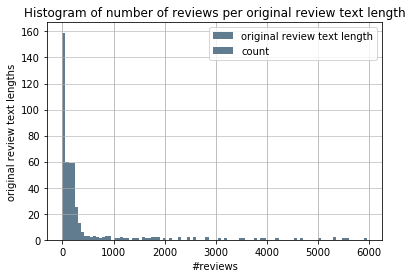



Histogram of reviews text length after cleaning the data
--------------------------------------------------------


--------------------------------
Analyze countTextFiltered column
--------------------------------

top 10 filtered review text lengths with maximum number of reviews:
+---------------------------+-----+
|filtered review text length|count|
+---------------------------+-----+
|                         13| 9643|
|                         12| 9536|
|                         14| 8921|
|                         11| 8880|
|                         15| 8136|
|                         10| 7685|
|                         16| 7418|
|                         17| 6756|
|                         18| 6132|
|                          9| 5806|
+---------------------------+-----+
only showing top 10 rows


 10 filtered review text lengths with minimum number of reviews:
+---------------------------+-----+
|filtered review text length|count|
+---------------------------+-----+
|         

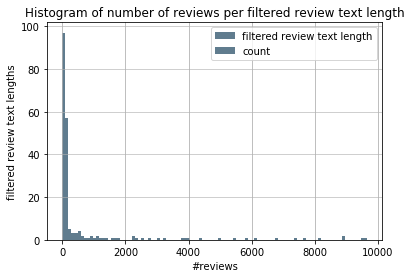

In addition to histograms display, we will explore exceptional length, using the magic_percentile method.
Scores grouped by percentiles review length:
+-----+-------------------------------------------+
|score|review text length magic percentiles values|
+-----+-------------------------------------------+
|5    |[34, 16, 10, 7, 5, 1, 1]                   |
|4    |[37, 17, 10, 7, 5, 3, 3]                   |
|3    |[40, 18, 10, 6, 5, 3, 3]                   |
|2    |[40, 18, 10, 7, 4, 3, 3]                   |
|1    |[39, 18, 10, 7, 5, 1, 1]                   |
+-----+-------------------------------------------+

Short review frequencies found.
Short reviews occuur in the data set at a frequency of '0.0001'
Short Review lengths to be filtered (ordered by index of the suitable score)
[1, 3, 3, 3, 1]
Filter out short reviews


In [5]:
displayTitle("Task 1")

displaySubTitle("Task1.a")
print("Get avarage length of review text (and more statistical data):\n")

mean_original_review_len = filteredData.agg(F.mean('countTextWords'))
mean_filtered_review_len = filteredData.agg(F.mean('countTextFiltered'))

print("Avarage number of words in original review text, (before stop words removal & tokenization): " + repr(mean_original_review_len.head()[0]) + " words.")
print("Avarage number of words in filtered review text, (after stop words removal & tokenization): " + repr(mean_filtered_review_len.head()[0]) + " words.")

max_original_review_len = filteredData.agg(F.max("countTextWords"))
min_original_review_len = filteredData.agg(F.min("countTextWords"))
max_filtered_review_len = filteredData.agg(F.max("countTextFiltered"))
min_filtered_review_len = filteredData.agg(F.min("countTextFiltered"))
print("Maximum number of words in original review text, (before words removal & tokenization): " + repr(max_original_review_len.head()[0]) + " words.")
print("Minimum number of words in original review text, (before words removal & tokenization): " + repr(min_original_review_len.head()[0]) + " words.")
print("Maximum number of words in filtered review text, (after words removal & tokenization): " + repr(max_filtered_review_len.head()[0]) + " words.")
print("Minimum number of words in filtered review text, (after words removal & tokenization): " + repr(min_filtered_review_len.head()[0]) + " words.")

displaySubTitle("Task1.b")
print("We should use " + textColumnTitle + " column, in order to predict score column")

displaySubTitle("Task1.c")
print("Check if there is missing data:")

missing_text_count = reviews_df.filter((reviews_df[textColumn] == "") | reviews_df[textColumn].isNull() | F.isnan(reviews_df[textColumn])).count()

# Release unused memory
del reviews_df

if missing_text_count == 0 :
    print("In the original input data set there is no missing data.")
else:
    print("In the original input data set, there are " + repr(missing_text_count) + " reviews with missing " + textColumnTitle)
    print("The missing data has been filtered out. Therefore in the filtered data there are no missing fields")
    
displaySubTitle("Task1.d")
print("Check exceptions in reviews:")

print("In order to understand the exceptional lengths in the reviews text, we will display a histograms of reviews text length, before and after cleaning the data")

displaySubTitle("Histogram of reviews text length before cleaning the data")
analyzeColumn(filteredData, "countTextWords", "original review text length", "review", 1)
displaySubTitle("Histogram of reviews text length after cleaning the data")
analyzeColumn(filteredData, "countTextFiltered", "filtered review text length", "review", 1)


print("In addition to histograms display, we will explore exceptional length, using the magic_percentile method.")

print("Scores grouped by percentiles review length:")
grp_window = Window.partitionBy('score')
magic_percentiles_values = '0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001'
magic_percentile_alias = "review text length magic percentiles values"
magic_percentile = F.expr('percentile_approx(countTextFiltered, array(' + magic_percentiles_values + '))')
magic_percentile_score_reviews_length_df = filteredData.groupBy('score').agg(magic_percentile.alias(magic_percentile_alias)).orderBy("score", ascending=False)
magic_percentile_score_reviews_length_df.show(truncate = False)

magic_percentiles = [row[0] for row in magic_percentile_score_reviews_length_df.select(magic_percentile_alias).collect()]
m = len(magic_percentiles)
n = len(magic_percentiles[0])
is_duplicate_column = False

for j in range(n - 1):
    counter = 0
    for i in range(m):
        if magic_percentiles[i][j] != magic_percentiles[i][j + 1]:
            break
    if i == m - 1:
        is_duplicate_column = True
        break

short_review_frequency = magic_percentiles_values.split(", ")[j]
if is_duplicate_column:
    print("Short review frequencies found.")

print("Short reviews occuur in the data set at a frequency of " + repr(short_review_frequency))
irrelevant_review_length_list = []
for magic_percentile in magic_percentiles:
    irrelevant_review_length_list.append(magic_percentile[j])
    
print("Short Review lengths to be filtered (ordered by index of the suitable score)")
print(irrelevant_review_length_list)

print("Filter out short reviews")
cleanData = filteredData.rdd.filter(lambda line: line['countTextFiltered'] >  irrelevant_review_length_list[int(line['Score']) - 1]).toDF()



-------------------------------------------------------------------------------------
In this section, we try to find a corellation between negative words and score column
-------------------------------------------------------------------------------------
We will try to find correlation between negative words in the text column and the score column
For this purpose, we will use the StopWordsRemover mechanism, in order to filter out negative words from the filtered text (filtered, because stop words have already been removed)
Define negative words remover, with the list of negative words
We use the StopWordsRemover mechanism to filter out negative words
Define poswitive words remover, with the list of positive words
We use the StopWordsRemover mechanism to filter out positive words
Remove negative words
Remove positive words
Display results, after removing negative & positive words
+---+-----+-------------------------------------------------------------------------------------------

'\nThe plot shows that there is no correlation between negative words and score.\nTherefore we should choose a different model for predicting score, based on the text.\n'

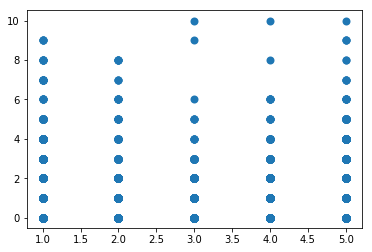

In [6]:
displayTitle("In this section, we try to find a corellation between negative words and score column")
print("We will try to find correlation between negative words in the text column and the score column")
print("For this purpose, we will use the StopWordsRemover mechanism, in order to filter out negative words from the filtered text (filtered, because stop words have already been removed)")

print("Define negative words remover, with the list of negative words")
print("We use the StopWordsRemover mechanism to filter out negative words")
negative_remover = StopWordsRemover(inputCol='textFiltered', outputCol="negative_filtered", stopWords=negative_words)

print("Define poswitive words remover, with the list of positive words")
print("We use the StopWordsRemover mechanism to filter out positive words")
positive_remover = StopWordsRemover(inputCol='textFiltered', outputCol="positive_filtered", stopWords=positive_words)

print("Remove negative words")
filteredDataWithoutNegativeWords = negative_remover.transform(filteredData).withColumn("count_negative_filtered", countTokens(col("negative_filtered")))

print("Remove positive words")
filteredDataWithoutPositiveWords = positive_remover.transform(filteredDataWithoutNegativeWords).withColumn("count_positive_filtered", countTokens(col("positive_filtered")))

filteredDataWithoutNegativeAndPositiveWords = filteredDataWithoutPositiveWords \
            .select("Id", "Score", 'Text', 'textFiltered', 'countTextfiltered', "negative_filtered", "count_negative_filtered", "positive_filtered", "count_positive_filtered") \
            .withColumn("count_negative", col('countTextFiltered') - col("count_negative_filtered")) \
            .withColumn("count_positive", col('countTextFiltered') - col("count_positive_filtered"))

# Release unused memory
del filteredDataWithoutNegativeWords
del filteredDataWithoutPositiveWords

print("Display results, after removing negative & positive words")
filteredDataWithoutNegativeAndPositiveWords.show(numOfTopRecords, truncate = False)

print("Sample " + repr(numOfSamplingDefaultRecords) + " records, in order to check for a possible correlation between negative words and score")
num_of_records = filteredDataWithoutNegativeAndPositiveWords.count()
percentage = 1.0 if num_of_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_records
df_pandas = filteredDataWithoutNegativeAndPositiveWords.sample(False, percentage, filterWordsSeed).toPandas()
plt.scatter(df_pandas['Score'], df_pandas['count_negative'],  lineWidth = 2.0)

# Release unused memory
del df_pandas

'''
The plot shows that there is no correlation between negative words and score.
Therefore we should choose a different model for predicting score, based on the text.
'''

In [7]:
displayTitle("Task1.e")
displaySubTitle("Examples of cynical and bad reviews:")
'''

Negative reviews identification strategy:
-----------------------------------------
It's easy - we just filter in all of the reviews with the lowest score (1).
These reviews must be negative, because of their poor score.

Cynical text identification strategy:
-------------------------------------
Usually, cynical review wiil have a low score, and a small amount of negative words.
The positive words will criticise the product, and present it in a negative way.
Therefore, out of the reviews with bad scores,
we filter in reviews with many positive words,
but just a few negative words (at most).
Hopefully, this approach will discover the cynical reviews.

'''

def df_sample_to_list(df, df_count, num_of_sampling_records, column1, column1Alias, column2, column2Alias):
    percentageRecords = 1.0 if df_count < num_of_sampling_records else num_of_sampling_records / df_count
    sample_list = [{column1Alias: x[column1], column2Alias: x[column2]} \
                    for x in df.sample(False, percentageRecords, sampleRecordsSeed).limit(num_of_sampling_records).collect()]
    return sample_list

def print_sample_list(sample_list, title, column1, column2):
    displaySubTitle(repr(len(sample_list)) + " " + title + ":")
    for row in sample_list:
        print("{}: {}".format(row[column1], row[column2]))

print("Fetch bad reviews...")
badReviewsDF = filteredDataWithoutNegativeAndPositiveWords.rdd.filter(lambda line: line['Score'] ==  1).toDF()
numBadReviewRecords = badReviewsDF.count()

# Release unused memory
del filteredDataWithoutNegativeAndPositiveWords

print("Fetch cynical reviews...")
cynicalReviewsDF = badReviewsDF.rdd.filter(lambda line: line['count_negative'] <= maximumNumOfNegativeWords and line['count_positive'] > minimalNumOfPositiveWords).toDF()
numCynicalReviewRecords = cynicalReviewsDF.count()

print(repr(numBadReviewRecords) + " examples of bad reviews:")
badReviewsDF.show(minNumOfTopRecords, truncate = False)

print("Out of the bad reviews, there are " + repr(numCynicalReviewRecords) + " examples of reviews that are probably cynical:")
cynicalReviewsDF.show(minNumOfTopRecords, truncate = False)

print("\nSample bad reviews")
bad_reviews_list =  df_sample_to_list(badReviewsDF, numBadReviewRecords, numOfSamplingBadRecords, 'Id', 'id', 'Text', 'text')
print_sample_list(bad_reviews_list, 'random bad reviews', 'id', 'text')

print("\nSample cynical reviews")
cynical_reviews_list =  df_sample_to_list(cynicalReviewsDF, numCynicalReviewRecords, numOfSamplingCynicalRecords, 'Id', 'id', 'Text', 'text')
print_sample_list(cynical_reviews_list, 'random cynical reviews', 'id', 'text')

# Release unused memory
del badReviewsDF
del cynicalReviewsDF
del bad_reviews_list
del cynical_reviews_list



-------
Task1.e
-------


Examples of cynical and bad reviews:
------------------------------------
Fetch bad reviews...
Fetch cynical reviews...
13333 examples of bad reviews:
+---+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+--------------+--------------+
|Id |Score|Text                                                     



10 random bad reviews:
----------------------
9323: i tried a double boxes of this when the donut shop  coffee i usually order was unavailable  while the coffee is pretty good the cups suck  a full 13 of the cups brewed are undrinkable  they are slow to brewcoffee maker has to work very hard and even then the cup retains an inordinate amount of water  checking some of the cups that left grounds in the brew showed that the filter was not properly installed  they could sell these at half the price listed and you still would pay too much due to all the wasted coffee  i believe we all have experienced a defective cup here or there but these are way beyond acceptable
208774: this product is poorly packed and half of the peanuts spilled out in the box and are no longer ebible i would recommend buying a product that is sealed in a better package
238294: my dogs nearly died from eating chicken jerky treats from china kidney damage is permanent please think twice about using this treat
242122

In [8]:
displayTitle("Task2 (a+b)")
'''
Type of model:
-------------
There is no need to predict a binary answer (positive or negative review), since the score column is provided.
Therefore, the score will be predicted based on the Text.
It means that this is a classification problem with 5 classes.
'''



-----------
Task2 (a+b)
-----------


'\nType of model:\n-------------\nThere is no need to predict a binary answer (positive or negative review), since the score column is provided.\nTherefore, the score will be predicted based on the Text.\nIt means that this is a classification problem with 5 classes.\n'

In [9]:
displaySubTitle("Task3")

'''
3.a Evaluation method:
Confusion matrix - https://towardsdatascience.com/model-evaluation-techniques-for-classification-models-eac30092c38b

The correct classification will be determined by the Score column.

-------------------
|True    |False   |
|Positive|Positive|
-------------------
|False   |True    |
|Negative|Negative|
-------------------


Accuarcy = (TP + TN) / (TP + TN + FP + FN)
Precission = TP / (TP + FP)
Recall = Sensitivity = TP / (TP + FN)

Accuarcy - how often is the model correct?
Precission - When the model predicts positive results, how often is it correct?
Recall - When it is actually the positive result, how often does it predict correctly?


In our case it's not a binary classification problem, but a multi-class classification problem.
Therefore the conusion matrix dimensions are: 5X5
Where the main diaogonal is the TP values.

All of the column (excluding TP values) are FN
All of the rows (excluding TP values) are FP

We have 5 classes that represents a given score: 1,2,3,4,5

The total number of test examples of any class,
would be the sum of the corresponding row (i.e the TP+FN for that class)

The total number of FN's for a class,
is the sum of values in the corresponding row (excluding the TP)

The total number of FP's for a class,
is the sum of values in the corresponding column (excluding the TP)

The total number of TN's for a class,
is the sum of all columns and rows, exluding that class' column and row

The Recall, commonly called sensitivity,
corespponds to the true-positive-rate of the considered class.




                        PREDICTED
         |--------------------------------------------
ACTUAL   |   1        2        3        4        5
       1 | TP[1]     E[1,2]   E[1,3]   E[1,4]   E[1,5]
       2 | E[2,1]    TP[2]    E[2,3]   E[2,4]   E[2,5]
       3 | E[3,1]    E[3,2]   TP[3]    E[3,4]   E[3,5]
       4 | E[4,1]    E[4,2]   E[4,3]   TP[4]    E[4,5]
       5 | E[5,1]    E[5,2]   E[5,3]   E[5,4]   TP[5]


Precision 1 = TP[1] / (TP[1] + E[2,1] + E[3,1] + E[4,1] + E[5,1])
Precision 2 = TP[2] / (TP[2] + E[1,2] + E[3,2] + E[4,2] + E[5,2])
Precision 3 = TP[3] / (TP[3] + E[1,3] + E[2,3] + E[4,3] + E[5,3])
Precision 4 = TP[4] / (TP[4] + E[1,4] + E[2,4] + E[3,4] + E[5,4])
Precision 5 = TP[5] / (TP[5] + E[1,5] + E[2,5] + E[3,5] + E[4,5])


Recall 1 = Sensitivity 1 = TP[1] / (TP[1] + E[1,2] + E[1,3] + E[1,4] + E[1,5])
Recall 2 = Sensitivity 2 = TP[2] / (TP[2] + E[2,1] + E[2,3] + E[2,4] + E[2,5])
Recall 3 = Sensitivity 3 = TP[3] / (TP[3] + E[3,1] + E[3,2] + E[3,3] + E[3,4])
Recall 4 = Sensitivity 4 = TP[4] / (TP[4] + E[4,1] + E[4,2] + E[4,3] + E[4,5])
Recall 5 = Sensitivity 5 = TP[5] / (TP[5] + E[5,1] + E[5,2] + E[5,3] + E[5,4])


3.b Features to be used:
Text column

3.c Model description:
A classifier that predict score (5 possible classes), based on text column (vectorized)

'''




Task3
-----


"\n3.a Evaluation method:\nConfusion matrix - https://towardsdatascience.com/model-evaluation-techniques-for-classification-models-eac30092c38b\n\nThe correct classification will be determined by the Score column.\n\n-------------------\n|True    |False   |\n|Positive|Positive|\n-------------------\n|False   |True    |\n|Negative|Negative|\n-------------------\n\n\nAccuarcy = (TP + TN) / (TP + TN + FP + FN)\nPrecission = TP / (TP + FP)\nRecall = Sensitivity = TP / (TP + FN)\n\nAccuarcy - how often is the model correct?\nPrecission - When the model predicts positive results, how often is it correct?\nRecall - When it is actually the positive result, how often does it predict correctly?\n\n\nIn our case it's not a binary classification problem, but a multi-class classification problem.\nTherefore the conusion matrix dimensions are: 5X5\nWhere the main diaogonal is the TP values.\n\nAll of the column (excluding TP values) are FN\nAll of the rows (excluding TP values) are FP\n\nWe have 5 c

In [10]:
displayTitle("Task4")
displaySubTitle("Vectorization of reviews")

cleanFilteredData = cleanData.select('id', 'Score', 'summaryFiltered')

# Release unused memory
del filteredData
del cleanData

print("Building binary hashing TF")
binaryHashingTF = HashingTF().setInputCol("summaryFiltered").setOutputCol("rawFeatures").setBinary(True)
binary_tf = binaryHashingTF.transform(cleanFilteredData)
print("Binary vectors of text as features:")
binary_tf.show(minNumOfTopRecords, truncate = False)

print("\n================================================================================================================\n")

print("Building hashing TF (non-binary)")
hashingTF = HashingTF().setInputCol("summaryFiltered").setOutputCol("rawFeatures")
tf = hashingTF.transform(cleanFilteredData)
print("Vectors of text as features (non-binary):")
tf.show(maxNumOfTopRecords, truncate = False)

# Release unused memory
del cleanFilteredData

print("\n================================================================================================================\n")

print("Building TF-IDF")
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(minDocFreq)
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)
print("TF-IDF features:")
tfidf.show(minNumOfTopRecords, truncate = False)



-----
Task4
-----


Vectorization of reviews
------------------------
Building binary hashing TF
Binary vectors of text as features:
+---+-----+--------------------------+-------------------------------------------------------+
|id |Score|summaryFiltered           |rawFeatures                                            |
+---+-----+--------------------------+-------------------------------------------------------+
|1  |5    |[good, quality, dog, food]|(262144,[75919,113432,121133,250865],[1.0,1.0,1.0,1.0])|
|2  |1    |[advertised]              |(262144,[232199],[1.0])                                |
+---+-----+--------------------------+-------------------------------------------------------+
only showing top 2 rows



Building hashing TF (non-binary)
Vectors of text as features (non-binary):
+---+-----+------------------------------+-------------------------------------------------------+
|id |Score|summaryFiltered               |rawFeatures                                         

In [11]:
displayTitle("Task5")
displaySubTitle("Splitting the data to train & test set with (0.7,0.3) ratio")

print("Selecting score & feature columns")
binary_tf_labeled = binary_tf.select('Score', 'rawFeatures') \
            .withColumn("Score", tf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label") \
            .withColumnRenamed("rawFeatures", "features")
tf_labeled = tf.select('Score', 'rawFeatures') \
            .withColumn("Score", tf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label") \
            .withColumnRenamed("rawFeatures", "features")
tfidf_labeled = tfidf.select('Score', 'features') \
            .withColumn("Score", tfidf["Score"].cast(IntegerType())) \
            .withColumnRenamed("Score", "label")

print("Splitting binart tf vectors to train & test sets")
train_set_binary_tf, test_set_binary_tf = binary_tf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)

# print("Splitting tf vectors to train & test sets")
# train_set_tf, test_set_tf = tf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)

print("Splitting tf-idf vectors to train & test sets")
train_set_tfidf, test_set_tfidf = tfidf_labeled.randomSplit(randomSplit, seed=dataSplitSeed)



-----
Task5
-----


Splitting the data to train & test set with (0.7,0.3) ratio
-----------------------------------------------------------
Selecting score & feature columns
Splitting binart tf vectors to train & test sets
Splitting tf-idf vectors to train & test sets


In [12]:
def classifyData(classifier, train_set, test_set, paramGrid):

    # Create k-fold CrossValidator (k = numOfFolds)
    cv = CrossValidator(estimator = classifier,
                        estimatorParamMaps = paramGrid,
                        evaluator = MulticlassClassificationEvaluator(),
                        numFolds = numOfFolds,
                        parallelism = crossValidationParallelism)

    # Run cross validations
    cvModel = cv.fit(train_set)

    # Predict data, based on the best model from cross-validation
    predictions = cvModel.transform(test_set)
    
    # Make prediction and test accuracy
    predictionsAndLabelsDF = predictions.select('label', 'prediction') \
    .withColumn("label", predictions["label"].cast(DoubleType()))

    # Convert predictionsAndLabels to rdd format
    if shift != 0:
        predictionsAndLabelsDF = predictionsAndLabelsDF.withColumn("prediction", predictions["prediction"] + shift)
    predictionsAndLabelsRDD = predictionsAndLabelsDF.rdd

    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionsAndLabelsRDD)
    
    return metrics

def evaluateClassifier(metrics):    
    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)

    # Statistics by class
    for label in sorted(scores):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    # Confusion matrix
    confusionMatrix = metrics.confusionMatrix()
    np.set_printoptions(formatter={'float': '{: 0.0f}'.format})
    print("confusionMatrix:")
    print(confusionMatrix)
    print("Confusion Matrix Values:")
    print(confusionMatrix.values)

In [13]:
displayTitle("Task6")
displaySubTitle("Run classifiers on TF vectors, and evaluate the results")

print("Set Naive Bayes classifier")
nb = NaiveBayes(smoothing=1.0, modelType='multinomial', featuresCol='features', labelCol='label')

print("Create ParamGrid for Cross Validation of naive bayes, with TF vectors")
nbTfParamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, smoothingGridParam)
               .addGrid(hashingTF.numFeatures, numOfFeaturesGridParam) # Number of features
               .build())

print("\nRun naive bayes with binary TF vectors ...")
nb_binary_tf_metrics = classifyData(nb, train_set_binary_tf, test_set_binary_tf, nbTfParamGrid)

print("\nEvalute metrics of naive bayes with binary TF vectors")
evaluateClassifier(nb_binary_tf_metrics)



-----
Task6
-----


Run classifiers on TF vectors, and evaluate the results
-------------------------------------------------------
Set Naive Bayes classifier
Create ParamGrid for Cross Validation of naive bayes, with TF vectors

Run naive bayes with binary TF vectors ...

Evalute metrics of naive bayes with binary TF vectors
Summary Stats
Precision = 0.7681700339710352
Recall = 0.7681700339710352
Class 1 precision = 0.5529860228716645
Class 1 recall = 0.6576004835297673
Class 2 precision = 0.09624145785876993
Class 2 recall = 0.6236162361623616
Class 3 precision = 0.16314606741573034
Class 3 recall = 0.6459074733096085
Class 4 precision = 0.10653126244524094
Class 4 recall = 0.5047169811320755
Class 5 precision = 0.9786832673080551
Class 5 recall = 0.7872135956704264
Weighted recall = 0.7681700339710352
Weighted precision = 0.9109515726966023
Weighted false positive rate = 0.12149993900758382
confusionMatrix:
DenseMatrix([[ 2176,  475,  236,  120,  302],
             [ 35,  169,  18

In [15]:
displayTitle("Task8")
displaySubTitle("Run classifiers on TF-IDF vectors, and evaluate the results")

print("Create ParamGrid for Cross Validation of naive bayes, with TF-IDF vectors")
nbTfIdfParamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, smoothingGridParam)
               .build())

print("\nRun naive bayes with TF-IDF vectors ...")
nb_tf_metrics = classifyData(nb, train_set_tfidf, test_set_tfidf, nbTfIdfParamGrid)

print("\nEvalute metrics of naive bayes with TF-IDF vectors")
evaluateClassifier(nb_tf_metrics)



-----
Task8
-----


Run classifiers on TF-IDF vectors, and evaluate the results
-----------------------------------------------------------
Create ParamGrid for Cross Validation of naive bayes, with TF-IDF vectors

Run naive bayes with TF-IDF vectors ...

Evalute metrics of naive bayes with TF-IDF vectors
Summary Stats
Precision = 0.7034909708564276
Recall = 0.7034909708564276
Class 1 precision = 0.6157560355781448
Class 1 recall = 0.5358248562582928
Class 2 precision = 0.29328018223234625
Class 2 recall = 0.3025851938895417
Class 3 precision = 0.3267415730337079
Class 3 recall = 0.3152645273200347
Class 4 precision = 0.30864197530864196
Class 4 recall = 0.287409605043575
Class 5 precision = 0.8256932654216186
Class 5 recall = 0.8520813730897765
Weighted recall = 0.7034909708564276
Weighted precision = 0.6961888976591001
Weighted false positive rate = 0.29163479754103194
confusionMatrix:
DenseMatrix([[ 2423,  485,  294,  293,  1027],
             [ 328,  515,  166,  161,  532],
     



-----
Task7
-----


Clustering the data
-------------------
Silhouette with squared euclidean distance = 0.1998191019249972
Cluster Centers: 
[ 0  0  0 ...  0  0  0]
[ 0  0  0 ...  0  0  0]
Sample 10000 records, in order to check for a possible correlation between cluster_0 and the given scores


Text(0.5, 1.0, 'cluster_1')

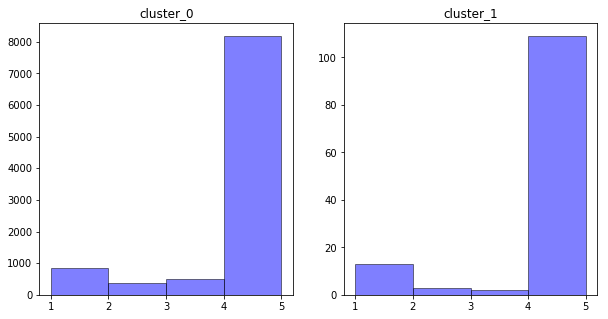

In [17]:
displayTitle("Task7")
displaySubTitle("Clustering the data")

'''
We will use k-means with k=2 clusters,
and try to find correlation between one cluster and negative reviews,
and a correlation between the second cluster and positive reviews.
'''

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
kmeansModel = kmeans.fit(train_set_tfidf)

# Make predictions
kmeansPredictions = kmeansModel.transform(test_set_tfidf)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(kmeansPredictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the clusters.
centers = kmeansModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Split the predictions data into 2 dataframes, based on the suitable cluster (0/1)
clusters_df = kmeansPredictions.select('label', 'prediction')
cluster_0_df = clusters_df.filter('prediction == 0')
cluster_1_df = clusters_df.filter('prediction == 1')

# Sample the 2 splitted dataframes and convert them to pandas data frame
print("Sample " + repr(numOfSamplingDefaultRecords) + " records, in order to check for a possible correlation between cluster_0 and the given scores")
num_of_cluster0_records = cluster_0_df.count()
cluster0_percentage = 1.0 if num_of_cluster0_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_cluster0_records
df_cluster0_pandas = cluster_0_df.sample(False, cluster0_percentage, clusterSeed).toPandas()
num_of_cluster1_records = cluster_1_df.count()
cluster1_percentage = 1.0 if num_of_cluster1_records < numOfSamplingDefaultRecords else numOfSamplingDefaultRecords / num_of_cluster1_records
df_cluster1_pandas = cluster_1_df.sample(False, cluster1_percentage, clusterSeed).toPandas()

# Plot 2 histograms of score & score count, corresponding to the 2 splitted dataframes.
fig, (left_plt, right_plt) = plt.subplots(ncols=2, figsize=(10, 5))
left_plt.hist(df_cluster0_pandas['label'],
         bins=scores,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
left_plt.set_title("cluster_0")

right_plt.hist(df_cluster1_pandas['label'],
         bins=scores,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
right_plt.set_title("cluster_1")

In [18]:
displayTitle("Task9")
displaySubTitle("Comparing the clustering results with the classification results")
'''
From the histograms in task 8 we can conclude that there is no correlation between clusters and scores.
Therefore negative/positive reviews should not be classified based on these 2 clusters

on the other hand converting 5 score classes,
into 2 classes (negative/positive reviews) is straight forward.
Score 5 is classified as positive review
Score 4 is classified as positive review
Score 1 is classified as negative review
Score 2 is classified as negative review
Score 3 is classified as negative review (For the balance, since most of the scores are 5)


Remarks:
We have run also logistic regression classifier,
but the performance of Logistic Regression is approximately the same as Naive Bayes classifier.
We have erased the logistic regression code, in order to save some running time.
We also compared binary and non-binary TF vectors for the classifiers - the results are approximately the same.
Therefore we also omited this attempt from the final code (in order to save running time).
'''



-----
Task9
-----


Comparing the clustering results with the classification results
----------------------------------------------------------------


'\nFrom the histograms in task 8 we can conclude that there is no correlation between clusters and scores.\nTherefore negative/positive reviews should not be classified based on these 2 clusters\n\non the other hand converting 5 score classes,\ninto 2 classes (negative/positive reviews) is straight forward.\nScore 5 is classified as positive review\nScore 4 is classified as positive review\nScore 1 is classified as negative review\nScore 2 is classified as negative review\nScore 3 is classified as negative review (For the balance, since most of the scores are 5)\n\n\nRemarks:\nWe have run also logistic regression classifier,\nbut the performance of Logistic Regression is approximately the same as Naive Bayes classifier.\nWe have erased the logistic regression code, in order to save some running time.\nWe also compared binary and non-binary TF vectors for the classifiers - the results are approximately the same.\nTherefore we also omited this attempt from the final code (in order to sav